In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
# tqdm is used for nice progress bars during training
from tqdm.notebook import tqdm

# Set random seeds for reproducibility across runs
np.random.seed(42)
torch.manual_seed(42)

# --- Configuration ---
# Number of samples for training and visualization
num_samples = 5000
# Training hyperparameters for the supervised NN
learning_rate = 1e-3
# More epochs might yield slightly better results but take longer
num_epochs = 250
# Increased hidden dimension for potentially better approximation
hidden_dim = 2048
# Device configuration (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# --- End Configuration ---

Using device: cuda


# 분포 변환 예제

**목표:** 단순한 NN 구조로 분포 변환을 쉽게 학습할 수 있을지 직접 구현해 본다.
1.  **박스-뮬러(Box-Muller) 변환:** "Ground truth"를 제공하는, 수학적으로 정확한 uniform에서 Gaussian으로의 변환이다.
2.  **Supervised Learning 신경망:** 입력 `(u1, u2)`에서 박스-뮬러 변환으로 생성된 *목표* 출력 `(x_bm, y_bm)`으로의 매핑을 명시적으로 학습하기 위해, MLP(`f_theta`)를 Mean Squared Error (MSE) loss를 사용하여 훈련한다.

**질문:** Supervised learning을 사용하는 비교적 쉬운 상황에서 NN이 수학적으로 정확한 변환을 완벽하게 복제할 수 있을까?

## 박스-뮬러 변환 (Ground Truth 변환)

먼저, uniform distribution 샘플과 이에 해당하는 Gaussian 샘플을 박스-뮬러 공식을 사용하여 생성한다. 이는 우리의 신경망이 입력 `(u1, u2)`로부터 예측하려고 시도할 목표 데이터 `(x_bm, y_bm)`을 제공한다.

In [2]:
# Uniform(0, 1)에서 u1과 u2에 대해 num_samples개의 무작위 숫자 생성
u1 = np.random.rand(num_samples)
u2 = np.random.rand(num_samples)

# (N, 2) 형태의 배열로 쌓기 (N = num_samples)
uniform_samples_np = np.stack([u1, u2], axis=1)

Visualizing the input uniform samples...


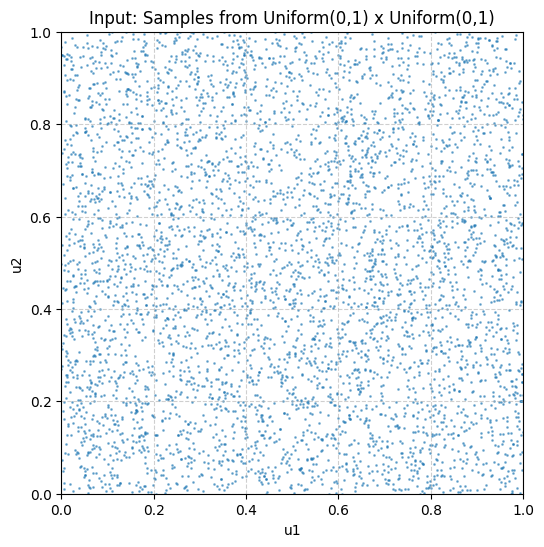

In [3]:
# 균등 분포 입력 샘플 시각화
print("Visualizing the input uniform samples...")
plt.figure(figsize=(6, 6))
plt.scatter(uniform_samples_np[:, 0], uniform_samples_np[:, 1], s=1, alpha=0.5)
plt.title('Input: Samples from Uniform(0,1) x Uniform(0,1)')
plt.xlabel('u1')
plt.ylabel('u2')
plt.xlim(0, 1)
plt.ylim(0, 1)

# 정사각형 모양을 명확하게 보기 위해 종횡비 동일하게 설정
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

$u_1, u_2 \sim \text{Uniform}(0, 1)$으로 주어진 경우, 다음과 같이 Box-Muller transform을 통해서 서로 독립인 정규 분포를 구할 수 있다. 

$x = \sqrt{-2 \ln(u_1)} \cos(2 \pi u_2)$

$y = \sqrt{-2 \ln(u_1)} \sin(2 \pi u_2)$

$x$와 $y$는 서로 독립인 정규 분포 $N(0, 1)$ 샘플이 된다.

In [4]:
# 박스-뮬러 변환을 적용하여 목표 출력 (x_bm, y_bm) 얻기
print("Applying Box-Muller transform to get target Gaussian samples...")

# log(0)인 경우를 피하기 위해 작은 epsilon 추가
epsilon = 1e-10
u1 = np.clip(u1, epsilon, 1.0)

x_bm = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
y_bm = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)

# 결과 가우시안 샘플을 (N, 2) 배열로 쌓기
target_gaussian_samples_np = np.stack([x_bm, y_bm], axis=1)

Applying Box-Muller transform to get target Gaussian samples...


Visualizing the target Gaussian samples (Box-Muller output)...


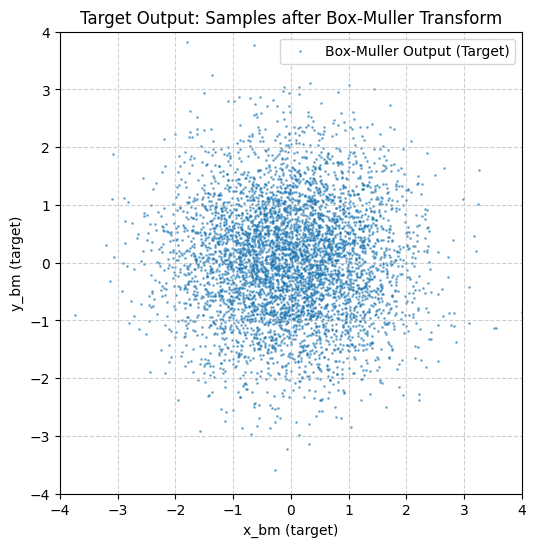

In [5]:
# 목표 박스-뮬러 출력 샘플 시각화
print("Visualizing the target Gaussian samples (Box-Muller output)...")
plt.figure(figsize=(6, 6))
plt.scatter(target_gaussian_samples_np[:, 0], target_gaussian_samples_np[:, 1], s=1, alpha=0.5, label='Box-Muller Output (Target)')
plt.title('Target Output: Samples after Box-Muller Transform')
plt.xlabel('x_bm (target)')
plt.ylabel('y_bm (target)')
# 표준 정규 분포에 적합한 플롯 제한 설정
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Checking the marginal distributions (histograms) of the target samples...


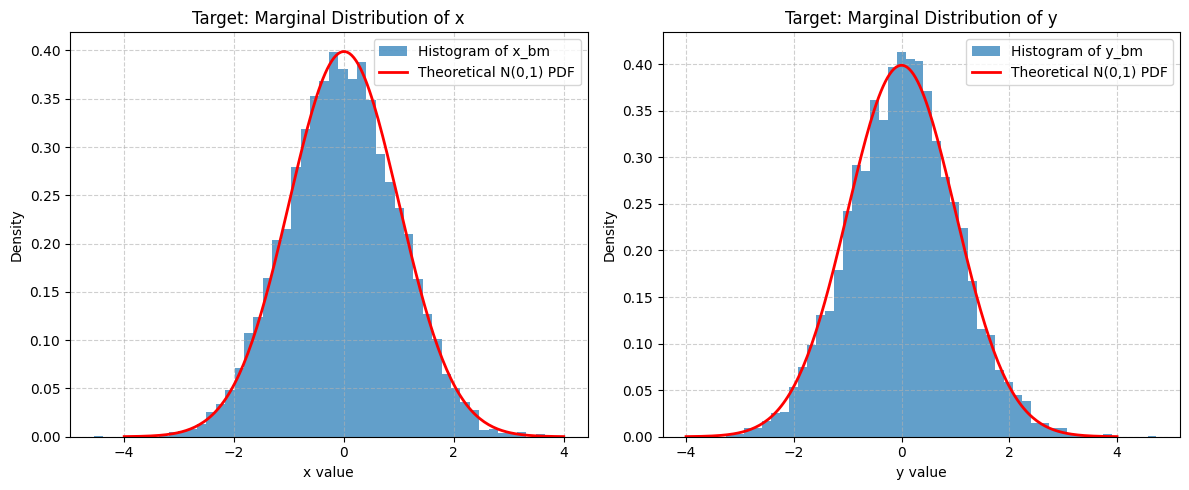

In [6]:
# Marginal distribution 확인 (히스토그램)
print("Checking the marginal distributions (histograms) of the target samples...")
plt.figure(figsize=(12, 5))
# 히스토그램 위에 겹쳐 그릴 N(0,1)의 이론적 PDF 정의
x_range = np.linspace(-4, 4, 200)
pdf_normal = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x_range**2)

# x_bm에 대한 히스토그램
plt.subplot(1, 2, 1)
plt.hist(target_gaussian_samples_np[:, 0], bins=50, density=True, alpha=0.7, label='Histogram of x_bm')
plt.plot(x_range, pdf_normal, 'r-', linewidth=2, label='Theoretical N(0,1) PDF')
plt.title('Target: Marginal Distribution of x')
plt.xlabel('x value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# y_bm에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(target_gaussian_samples_np[:, 1], bins=50, density=True, alpha=0.7, label='Histogram of y_bm')
plt.plot(x_range, pdf_normal, 'r-', linewidth=2, label='Theoretical N(0,1) PDF')
plt.title('Target: Marginal Distribution of y')
plt.xlabel('y value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout() # 서브플롯 파라미터를 타이트하게 조정
plt.show()

**관찰:** 박스-뮬러 변환은 원형 산점도와 이론적인 N(0,1) 곡선과 일치하는 종 모양의 히스토그램에서 볼 수 있듯이, Uniform distribution을 Normal distribution으로 성공적으로 변환했다.

## 파트 2: Supervised Learning 시도

이제, 입력 `(u1, u2)`에서 목표 `(x_bm, y_bm)`으로의 매핑을 Mean Squared Error (MSE) loss를 사용하여 학습하도록 MLP를 정의하고 훈련시킨다.

In [7]:
# PyTorch를 사용한 간단한 MLP 모델 정의
class SimpleMLP(nn.Module):
    """ 간단한  MLP """
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),   # Input layer -> Hidden layer
            nn.ReLU(),                          # ReLU activation function
            nn.Linear(hidden_dim, hidden_dim),  # Hidden layer -> Hidden layer
            nn.ReLU(),                          # ReLU activation function
            nn.Linear(hidden_dim, output_dim)   # Hidden layer -> Output layer
        )

    def forward(self, x):
        """ 모델의 forward pass 정의. """
        return self.network(x)

# 모델 인스턴스화 및 적절한 장치(CPU 또는 GPU)로 이동
model = SimpleMLP(hidden_dim=hidden_dim).to(device)
print("MLP Model Structure:")
print(model)

# 학습 가능한 파라미터 수 계산
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params:,}")

MLP Model Structure:
SimpleMLP(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=2, bias=True)
  )
)
Number of trainable parameters: 4,206,594


In [8]:
print("Preparing data tensors...")
# numpy 배열을 PyTorch 텐서로 변환
input_tensor  = torch.tensor(uniform_samples_np, dtype=torch.float32).to(device)
target_tensor = torch.tensor(target_gaussian_samples_np, dtype=torch.float32).to(device)

print(f"Input tensor shape: {input_tensor.shape}, Device: {input_tensor.device}")
print(f"Target tensor shape: {target_tensor.shape}, Device: {target_tensor.device}")

Preparing data tensors...
Input tensor shape: torch.Size([5000, 2]), Device: cuda:0
Target tensor shape: torch.Size([5000, 2]), Device: cuda:0


In [9]:
# Optimizer 및 Loss Function 설정
# 간단히 Adam과 MSE 사용
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [10]:
# Training Loop
print(f"Starting supervised training for {num_epochs} epochs...")
losses = [] # 플롯을 위해 loss 값 저장 리스트
model.train() # 모델을 training 모드로 설정

for epoch in tqdm(range(num_epochs), desc="Training MLP"):
    # Forward pass: 입력을 모델에 통과시켜 예측 출력 계산
    outputs = model(input_tensor)

    # 예측 출력과 목표 출력 간의 loss 계산
    loss = criterion(outputs, target_tensor)

    # Backward pass 및 optimization:
    optimizer.zero_grad() # 이전 gradient 초기화
    loss.backward()       # 모델 파라미터에 대한 loss의 gradient 계산
    optimizer.step()      # optimizer를 사용하여 모델 파라미터 업데이트

    # 이 에포크의 loss 기록
    losses.append(loss.item())

print(f"Training finished. Final Loss: {losses[-1]:.6f}")

Starting supervised training for 250 epochs...


Training MLP:   0%|          | 0/250 [00:00<?, ?it/s]

Training finished. Final Loss: 0.003305


Plotting training loss...


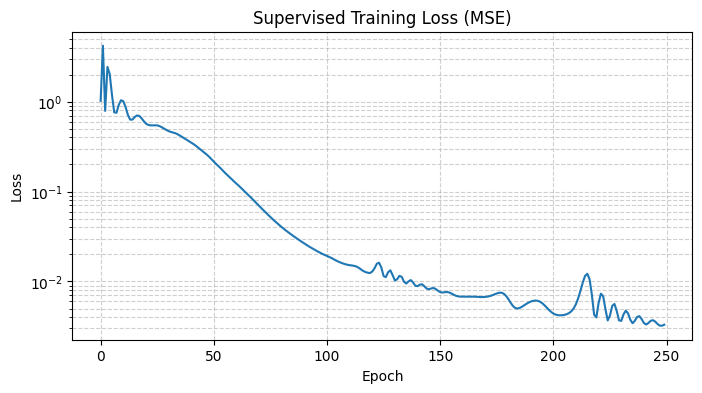

In [11]:
# Training loss 플로팅
print("Plotting training loss...")
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title('Supervised Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log') # 초기 급격한 감소와 이후 안정 상태를 보기 위해 로그 스케일 사용
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.show()

**관찰:** Training loss가 크게 감소했으며, 이는 신경망이 예측과 목표 박스-뮬러 출력 간의 MSE를 최소화하기 위해 파라미터(`theta`)를 조정하는 법을 *학습*했음을 나타낸다.

## 파트 3: 훈련된 모델 평가

동일한 균등 분포 입력을 사용하여 *훈련된* 모델로부터 예측값을 얻고 결과를 시각화한다. 이 예측값을 목표 박스-뮬러 출력과 직접 비교한다.

In [12]:
# 훈련된 모델로부터 예측 얻기
print("Getting predictions from the trained supervised model...")
model.eval() # 모델을 evaluation 모드로 설정 (Dropout, BatchNorm을 쓴 경우에는 중요함.)
with torch.no_grad():
    predicted_output_tensor = model(torch.rand_like(input_tensor))

# 예측값을 CPU로 다시 이동 (GPU 사용 시)하고 NumPy 배열로 변환
predicted_gaussian_samples_np = predicted_output_tensor.cpu().numpy()

Getting predictions from the trained supervised model...


Visualizing the output of the supervised NN...


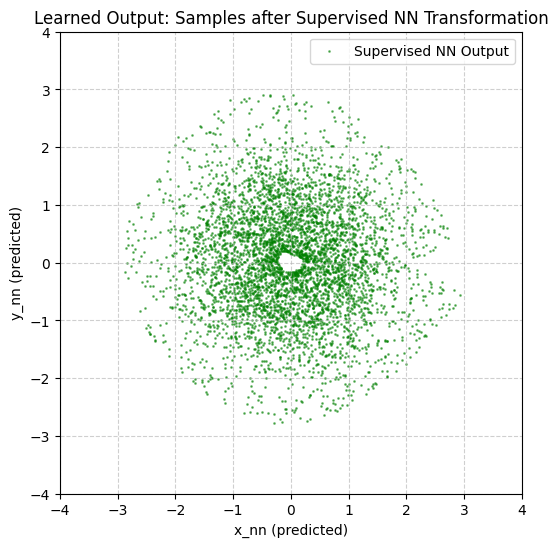

In [13]:
# Supervised NN 출력 샘플 시각화
print("Visualizing the output of the supervised NN...")
plt.figure(figsize=(6, 6))
plt.scatter(predicted_gaussian_samples_np[:, 0], predicted_gaussian_samples_np[:, 1],
            s=1, alpha=0.5, label='Supervised NN Output', color='green')
plt.title('Learned Output: Samples after Supervised NN Transformation')
plt.xlabel('x_nn (predicted)')
plt.ylabel('y_nn (predicted)')
# 직접 비교를 위해 목표 플롯과 동일한 제한 사용
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Checking the marginal distributions (histograms) of the supervised NN output...


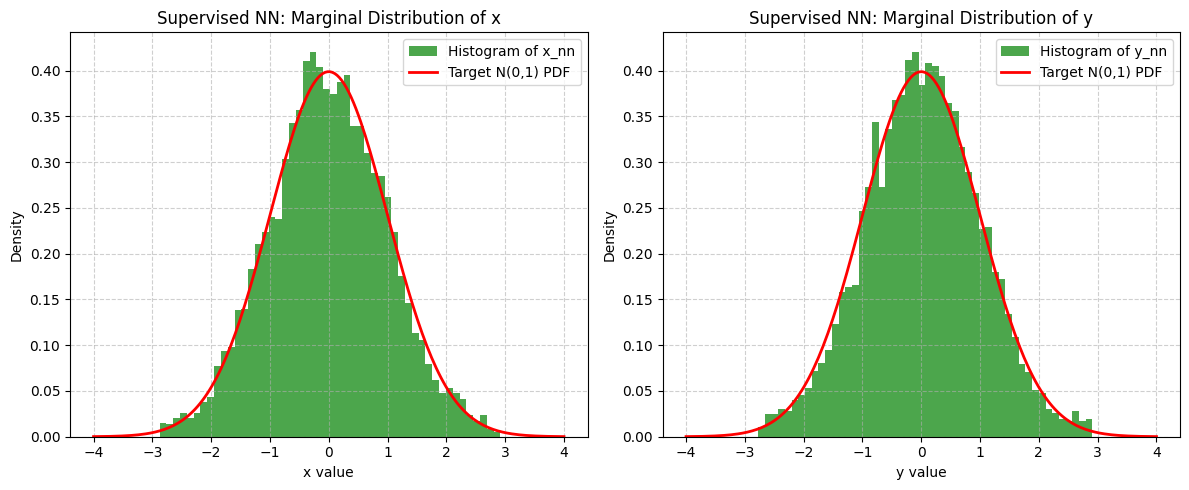

In [14]:
# Supervised NN 주변 분포 확인
print("Checking the marginal distributions (histograms) of the supervised NN output...")
plt.figure(figsize=(12, 5))

# 예측된 x_nn에 대한 히스토그램
plt.subplot(1, 2, 1)
plt.hist(predicted_gaussian_samples_np[:, 0], bins=50, density=True, alpha=0.7, label='Histogram of x_nn', color='green')
plt.plot(x_range, pdf_normal, 'r-', linewidth=2, label='Target N(0,1) PDF')
plt.title('Supervised NN: Marginal Distribution of x')
plt.xlabel('x value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# 예측된 y_nn에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(predicted_gaussian_samples_np[:, 1], bins=50, density=True, alpha=0.7, label='Histogram of y_nn', color='green')
plt.plot(x_range, pdf_normal, 'r-', linewidth=2, label='Target N(0,1) PDF')
plt.title('Supervised NN: Marginal Distribution of y')
plt.xlabel('y value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**관측** 훈련된 신경망은 전반적인 구조는 대략 학습했지만, Box-Muller 변환의 결과인 목표 분포와 완벽히 일치하지는 않는다. 특히 중심 부분의 밀도나 히스토그램 형태에서 차이가 관찰된다.

**생성 모델 동기 부여:**
실제 생성 문제(예: 이미지 생성)에서는 변환에 대한 명시적인 입력-목표 쌍이 없고, 단지 목표 분포 $p_{\text{data}}(x)$의 샘플만 주어진다. 따라서 pointwise 오차 최소화 대신, 샘플만을 이용해 생성된 분포 $p_{\text{gen}}(x)$를 실제 데이터 분포 $p_{\text{data}}(x)$와 일치시키는 데 특화된 방법론(예: GAN, Diffusion Model)이 필요하다.